In [1]:
from pathlib import Path

print("Here are files in outputs/:")
for p in Path("outputs").rglob("*"):
    if p.is_file():
        print(p)


Here are files in outputs/:
outputs/tables/phase3_engineered.csv.gz


In [2]:
from pathlib import Path
import pandas as pd
import numpy as np

data_path = Path("outputs") / "tables" / "phase3_engineered.csv.gz"
if not data_path.exists():
    raise FileNotFoundError(f"Missing file: {data_path.resolve()}")

df = pd.read_csv(data_path, compression="gzip", low_memory=False)

print("✅ Loaded engineered:", df.shape)


✅ Loaded engineered: (300000, 50)


In [3]:
from pathlib import Path
import pandas as pd
import numpy as np

# Always anchor to project root (one level above /notebooks)
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

OUT_TABLES = ROOT / "outputs" / "tables"
OUT_TABLES.mkdir(parents=True, exist_ok=True)

print("✅ ROOT:", ROOT)
print("✅ OUT_TABLES:", OUT_TABLES)
print("✅ Exists outputs?", (ROOT / "outputs").exists())


✅ ROOT: /Users/sanghati/research/accountable-interpretation
✅ OUT_TABLES: /Users/sanghati/research/accountable-interpretation/outputs/tables
✅ Exists outputs? True


In [4]:
files = sorted(OUT_TABLES.glob("phase3_engineered*"))
print("✅ Found files:")
for f in files:
    print(" -", f.name)


✅ Found files:
 - phase3_engineered.csv.gz


In [5]:
csv_gz = OUT_TABLES / "phase3_engineered.csv.gz"
csv_plain = OUT_TABLES / "phase3_engineered.csv"
pkl = OUT_TABLES / "phase3_engineered.pkl"

if csv_gz.exists():
    df = pd.read_csv(csv_gz, compression="gzip", low_memory=False)
    print("✅ Loaded:", csv_gz.name, df.shape)

elif csv_plain.exists():
    df = pd.read_csv(csv_plain, low_memory=False)
    print("✅ Loaded:", csv_plain.name, df.shape)

elif pkl.exists():
    df = pd.read_pickle(pkl)
    print("✅ Loaded:", pkl.name, df.shape)

else:
    raise FileNotFoundError(
        "No engineered Phase 3 file found. Expected one of:\n"
        f"- {csv_gz}\n- {csv_plain}\n- {pkl}"
    )


✅ Loaded: phase3_engineered.csv.gz (300000, 50)


In [6]:
from pathlib import Path
import pandas as pd
import numpy as np

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
data_path = ROOT / "outputs" / "tables" / "phase3_engineered.csv.gz"

df = pd.read_csv(data_path, compression="gzip", low_memory=False)
print("✅ Loaded engineered:", df.shape)
print("✅ Columns:", len(df.columns))


✅ Loaded engineered: (300000, 50)
✅ Columns: 50


In [7]:
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
print("ROOT =", ROOT)

# Look for any phase3_engineered file anywhere in the repo
hits = list(ROOT.rglob("phase3_engineered.*"))
print("Found:", len(hits))
for h in hits[:50]:
    print("-", h)


ROOT = /Users/sanghati/research/accountable-interpretation
Found: 3
- /Users/sanghati/research/accountable-interpretation/outputs/tables/phase3_engineered.csv.gz
- /Users/sanghati/research/accountable-interpretation/notebooks/outputs/tables/phase3_engineered.csv.gz
- /Users/sanghati/research/accountable-interpretation/notebooks/notebooks/outputs/tables/phase3_engineered.csv.gz


In [8]:
from pathlib import Path
import pandas as pd

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

# Your engineered file is inside notebooks/outputs/...
data_path = ROOT / "notebooks" / "outputs" / "tables" / "phase3_engineered.csv.gz"

assert data_path.exists(), f"Missing: {data_path}"

df = pd.read_csv(data_path, compression="gzip", low_memory=False)

print("✅ Loaded engineered:", df.shape)
print("✅ Example columns:", df.columns[:15].tolist())


✅ Loaded engineered: (300000, 50)
✅ Example columns: ['#AlleleID', 'Type', 'Name', 'GeneID', 'GeneSymbol', 'HGNC_ID', 'ClinicalSignificance', 'ClinSigSimple', 'LastEvaluated', 'RS# (dbSNP)', 'nsv/esv (dbVar)', 'RCVaccession', 'PhenotypeIDS', 'PhenotypeList', 'Origin']


In [9]:
from pathlib import Path
import shutil

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

src = ROOT / "notebooks" / "outputs" / "tables" / "phase3_engineered.csv.gz"
dst_dir = ROOT / "outputs" / "tables"
dst_dir.mkdir(parents=True, exist_ok=True)
dst = dst_dir / "phase3_engineered.csv.gz"

shutil.copy2(src, dst)
print("✅ Copied to:", dst)


✅ Copied to: /Users/sanghati/research/accountable-interpretation/outputs/tables/phase3_engineered.csv.gz


In [10]:
# ---- Phase 4.1: Sanity check ----
required_cols = [
    "years_since_review",
    "NumberSubmitters_num",
    "ConfidenceLevel",
    "ClinicalSignificance",
    "ReviewStatus",
    "conflicting",
    "ReclassificationRiskTier"
]

missing = [c for c in required_cols if c not in df.columns]

print("Missing columns:", missing)
assert len(missing) == 0, "❌ Missing required columns — stop here"
print("✅ All required columns present")


Missing columns: []
✅ All required columns present


In [11]:
# ---- Phase 4.2: Target definition (proxy instability label) ----

df_model = df.copy()

df_model["y"] = df_model["ReclassificationRiskTier"].isin(
    ["High", "Critical"]
).astype(int)

print("Target distribution:")
print(df_model["y"].value_counts(normalize=True))


Target distribution:
y
0    0.702097
1    0.297903
Name: proportion, dtype: float64


In [12]:
# ---- Phase 4.3: Feature selection ----

num_features = [
    "years_since_review",
    "NumberSubmitters_num"
]

cat_features = [
    "ConfidenceLevel",
    "ClinicalSignificance",
    "ReviewStatus"
]

bool_features = ["conflicting"]

X = df_model[num_features + cat_features + bool_features]
y = df_model["y"]

print("X shape:", X.shape)
print("y mean:", y.mean())


X shape: (300000, 6)
y mean: 0.29790333333333335


In [13]:
# ---- Phase 4.4: Train interpretable ML model ----

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_features),
        ("bool", SimpleImputer(strategy="most_frequent"), bool_features),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features)
    ]
)

model = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

model.fit(X_train, y_train)

proba = model.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, proba))
print("PR-AUC :", average_precision_score(y_test, proba))


ImportError: dlopen(/opt/miniconda3/envs/phdproj/lib/python3.11/site-packages/pyarrow/lib.cpython-311-darwin.so, 0x0002): Symbol not found: __ZN4absl12lts_2025012712log_internal10LogMessagelsIhTnNSt3__19enable_ifIXntsr4absl16HasAbslStringifyIT_EE5valueEiE4typeELi0EEERS2_RKS6_
  Referenced from: <09A493DC-7C8A-3DB5-B8FF-4F71CCCC9DB1> /opt/miniconda3/envs/phdproj/lib/libre2.11.dylib
  Expected in:     <35FB928A-2D13-39BB-82C2-48D6EB027718> /opt/miniconda3/envs/phdproj/lib/libabsl_log_internal_message.2501.0.0.dylib

In [14]:
# ---- Phase 4.4: Train interpretable ML model ----

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.25,
    random_state=42,
    stratify=y
)

preprocess = ColumnTransformer(
    transformers=[
        ("num", SimpleImputer(strategy="median"), num_features),
        ("bool", SimpleImputer(strategy="most_frequent"), bool_features),
        ("cat", Pipeline([
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_features)
    ]
)

model = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(
        max_iter=2000,
        class_weight="balanced",
        solver="lbfgs"
    ))
])

model.fit(X_train, y_train)

proba = model.predict_proba(X_test)[:, 1]

print("ROC-AUC:", roc_auc_score(y_test, proba))
print("PR-AUC :", average_precision_score(y_test, proba))


ImportError: dlopen(/opt/miniconda3/envs/phdproj/lib/python3.11/site-packages/pyarrow/lib.cpython-311-darwin.so, 0x0002): Symbol not found: __ZN4absl12lts_2025012712log_internal10LogMessagelsIhTnNSt3__19enable_ifIXntsr4absl16HasAbslStringifyIT_EE5valueEiE4typeELi0EEERS2_RKS6_
  Referenced from: <09A493DC-7C8A-3DB5-B8FF-4F71CCCC9DB1> /opt/miniconda3/envs/phdproj/lib/libre2.11.dylib
  Expected in:     <35FB928A-2D13-39BB-82C2-48D6EB027718> /opt/miniconda3/envs/phdproj/lib/libabsl_log_internal_message.2501.0.0.dylib

In [15]:
# --- Phase 4.4 (NO sklearn): Train interpretable logistic model with pure numpy/pandas ---

import numpy as np
import pandas as pd

# 1) Target: use your engineered tier (proxy label)
#    y=1 for High/Critical, else 0
if "ReclassificationRiskTier" not in df.columns:
    raise KeyError("Missing column: ReclassificationRiskTier (create it in Phase 3 first).")

y = df["ReclassificationRiskTier"].isin(["High", "Critical"]).astype(int).to_numpy()

# 2) Features (use only columns that exist)
#    We will auto-pick from these candidates.
num_candidates  = ["years_since_review", "NumberSubmitters_num"]
cat_candidates  = ["ConfidenceLevel", "ClinicalSignificance", "ReviewStatus"]
bool_candidates = ["conflicting"]

num_cols  = [c for c in num_candidates  if c in df.columns]
cat_cols  = [c for c in cat_candidates  if c in df.columns]
bool_cols = [c for c in bool_candidates if c in df.columns]

if len(num_cols) + len(cat_cols) + len(bool_cols) == 0:
    raise ValueError("No feature columns found. Check Phase 3 engineered columns exist.")

X_df = df[num_cols + cat_cols + bool_cols].copy()

# Clean booleans -> 0/1
for c in bool_cols:
    X_df[c] = X_df[c].astype("float").fillna(0.0)

# Numeric -> float, fill missing
for c in num_cols:
    X_df[c] = pd.to_numeric(X_df[c], errors="coerce")

# One-hot encode categorical + fill missing
X_df = pd.get_dummies(X_df, columns=cat_cols, dummy_na=True)

# Fill remaining NaNs
X_df = X_df.fillna(X_df.median(numeric_only=True))

X = X_df.to_numpy(dtype=np.float64)

print("✅ X shape:", X.shape, "| positives:", int(y.sum()), "| pos_rate:", float(y.mean()))

# 3) Stratified train/test split (no sklearn)
rng = np.random.default_rng(42)
pos_idx = np.where(y == 1)[0]
neg_idx = np.where(y == 0)[0]
rng.shuffle(pos_idx); rng.shuffle(neg_idx)

test_frac = 0.25
pos_test = pos_idx[: int(len(pos_idx)*test_frac)]
neg_test = neg_idx[: int(len(neg_idx)*test_frac)]
test_idx = np.concatenate([pos_test, neg_test])
train_idx = np.setdiff1d(np.arange(len(y)), test_idx)

rng.shuffle(train_idx); rng.shuffle(test_idx)

X_train, y_train = X[train_idx], y[train_idx]
X_test,  y_test  = X[test_idx],  y[test_idx]

# 4) Standardize features (important for logistic stability)
mu = X_train.mean(axis=0)
sd = X_train.std(axis=0) + 1e-9
X_train_s = (X_train - mu) / sd
X_test_s  = (X_test  - mu) / sd

# 5) Logistic regression (L2) via gradient descent (stable + simple)
def sigmoid(z):
    z = np.clip(z, -35, 35)
    return 1.0 / (1.0 + np.exp(-z))

def fit_logistic_l2(X, y, lr=0.05, steps=600, l2=1.0):
    n, d = X.shape
    w = np.zeros(d, dtype=np.float64)
    b = 0.0
    for i in range(steps):
        p = sigmoid(X @ w + b)
        # gradients
        gw = (X.T @ (p - y)) / n + l2 * w
        gb = float(np.mean(p - y))
        w -= lr * gw
        b -= lr * gb
        if (i+1) % 100 == 0:
            # loss for monitoring
            eps = 1e-9
            loss = -np.mean(y*np.log(p+eps) + (1-y)*np.log(1-p+eps)) + 0.5*l2*np.sum(w*w)
            print(f"step {i+1:4d} | loss {loss:.4f}")
    return w, b

w, b = fit_logistic_l2(X_train_s, y_train, lr=0.05, steps=600, l2=0.5)

proba = sigmoid(X_test_s @ w + b)

# 6) Metrics (ROC-AUC + PR-AUC) without sklearn
def roc_auc(y_true, y_score):
    order = np.argsort(-y_score)
    y = y_true[order]
    P = y.sum()
    N = len(y) - P
    if P == 0 or N == 0:
        return np.nan
    tps = np.cumsum(y)
    fps = np.cumsum(1 - y)
    tpr = tps / P
    fpr = fps / N
    return np.trapz(tpr, fpr)

def pr_auc(y_true, y_score):
    order = np.argsort(-y_score)
    y = y_true[order]
    P = y.sum()
    if P == 0:
        return np.nan
    tps = np.cumsum(y)
    fps = np.cumsum(1 - y)
    precision = tps / np.maximum(tps + fps, 1)
    recall = tps / P
    return np.trapz(precision, recall)

roc = roc_auc(y_test, proba)
pra = pr_auc(y_test, proba)

pred = (proba >= 0.5).astype(int)
tp = int(((pred==1) & (y_test==1)).sum())
fp = int(((pred==1) & (y_test==0)).sum())
tn = int(((pred==0) & (y_test==0)).sum())
fn = int(((pred==0) & (y_test==1)).sum())

print("\n✅ ROC-AUC:", roc)
print("✅ PR-AUC :", pra)
print("Confusion @0.5 => TP,FP,TN,FN:", tp, fp, tn, fn)

# 7) Save risk score back to df (aligned to original rows)
df["model_risk_proba"] = np.nan
df.loc[test_idx, "model_risk_proba"] = proba

print("\n✅ Added column: model_risk_proba (filled for test rows).")


✅ X shape: (300000, 95) | positives: 89371 | pos_rate: 0.29790333333333335
step  100 | loss 0.3753
step  200 | loss 0.3612
step  300 | loss 0.3581
step  400 | loss 0.3573
step  500 | loss 0.3571
step  600 | loss 0.3571

✅ ROC-AUC: 0.9965282018538872
✅ PR-AUC : 0.9925691302432623
Confusion @0.5 => TP,FP,TN,FN: 20698 89 52568 1644

✅ Added column: model_risk_proba (filled for test rows).


/var/folders/7x/42f5r3c50870bwy_fq7n4v0m0000gn/T/ipykernel_14788/572981927.py:108: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(tpr, fpr)
/var/folders/7x/42f5r3c50870bwy_fq7n4v0m0000gn/T/ipykernel_14788/572981927.py:120: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return np.trapz(precision, recall)


In [16]:
from pathlib import Path
import numpy as np
import pandas as pd

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
OUT = ROOT / "outputs" / "phase4"
(OUT / "tables").mkdir(parents=True, exist_ok=True)
(OUT / "figures").mkdir(parents=True, exist_ok=True)

# 1) Make sure we have full-df risk scores (not only test rows)
# If you only filled test rows earlier, compute proba for ALL rows now.
# We must reuse X_df column order exactly like training.
# So: re-build X_df the same way as in Cell 4 (dummies + fill) and apply w,b,mu,sd.

# ---- Recreate feature dataframe exactly ----
num_candidates  = ["years_since_review", "NumberSubmitters_num"]
cat_candidates  = ["ConfidenceLevel", "ClinicalSignificance", "ReviewStatus"]
bool_candidates = ["conflicting"]

num_cols  = [c for c in num_candidates  if c in df.columns]
cat_cols  = [c for c in cat_candidates  if c in df.columns]
bool_cols = [c for c in bool_candidates if c in df.columns]

X_all = df[num_cols + cat_cols + bool_cols].copy()

for c in bool_cols:
    X_all[c] = X_all[c].astype("float").fillna(0.0)
for c in num_cols:
    X_all[c] = pd.to_numeric(X_all[c], errors="coerce")

X_all = pd.get_dummies(X_all, columns=cat_cols, dummy_na=True)

# IMPORTANT: align columns to training matrix X_df used in Cell 4
# Cell 4 created X_df; it should still exist in memory. If not, we fail fast.
if "X_df" not in globals():
    raise NameError("X_df not found. Please re-run Cell 4 so X_df exists (feature columns for training).")

X_all = X_all.reindex(columns=X_df.columns, fill_value=0)
X_all = X_all.fillna(X_all.median(numeric_only=True))

X_all_np = X_all.to_numpy(dtype=np.float64)
X_all_s  = (X_all_np - mu) / sd

def sigmoid(z):
    z = np.clip(z, -35, 35)
    return 1.0 / (1.0 + np.exp(-z))

df["model_risk_proba"] = sigmoid(X_all_s @ w + b)

# 2) Create model risk tiers from probability (simple thresholds)
# You can tune later; these are reasonable defaults.
bins = [-np.inf, 0.25, 0.50, 0.75, np.inf]
labels = ["Low", "Moderate", "High", "Critical"]
df["model_risk_tier"] = pd.cut(df["model_risk_proba"], bins=bins, labels=labels)

print("✅ model_risk_proba filled for ALL rows")
print(df["model_risk_tier"].value_counts(dropna=False))

# 3) PI-ready “review-first” table (top N)
# Choose columns that exist safely
keep_cols = []
preferred_cols = [
    "VariationID", "AlleleID", "Name",
    "GeneSymbol", "HGNC_ID", "GeneID",
    "ClinicalSignificance", "ReviewStatus",
    "years_since_review", "NumberSubmitters_num",
    "conflicting",
    "ReclassificationRiskTier",  # your engineered proxy tier
    "model_risk_proba", "model_risk_tier"
]
for c in preferred_cols:
    if c in df.columns:
        keep_cols.append(c)

topN = 200
top = df.sort_values("model_risk_proba", ascending=False).head(topN)[keep_cols].copy()

top_path = OUT / "tables" / "top200_review_first_variants.csv"
top.to_csv(top_path, index=False)
print("✅ Saved:", top_path)

# 4) Summary numbers for clinical framing
summary = (
    df.assign(is_pathogenic=df["ClinicalSignificance"].astype(str).str.contains("Pathogenic", case=False, na=False))
      .groupby(["is_pathogenic", "model_risk_tier"])
      .size()
      .reset_index(name="n")
)
summary_path = OUT / "tables" / "clinical_summary_by_pathogenic_and_tier.csv"
summary.to_csv(summary_path, index=False)
print("✅ Saved:", summary_path)

# 5) Save a compact “Phase4 scored dataset” for later notebooks (CSV gzip, no parquet needed)
scored_path = OUT / "tables" / "phase4_scored.csv.gz"
df.to_csv(scored_path, index=False, compression="gzip")
print("✅ Saved:", scored_path)


✅ model_risk_proba filled for ALL rows
model_risk_tier
Low         195509
High         68980
Moderate     21323
Critical     14188
Name: count, dtype: int64
✅ Saved: /Users/sanghati/research/accountable-interpretation/outputs/phase4/tables/top200_review_first_variants.csv


/var/folders/7x/42f5r3c50870bwy_fq7n4v0m0000gn/T/ipykernel_14788/4058170458.py:85: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["is_pathogenic", "model_risk_tier"])


✅ Saved: /Users/sanghati/research/accountable-interpretation/outputs/phase4/tables/clinical_summary_by_pathogenic_and_tier.csv
✅ Saved: /Users/sanghati/research/accountable-interpretation/outputs/phase4/tables/phase4_scored.csv.gz


Matplotlib is building the font cache; this may take a moment.


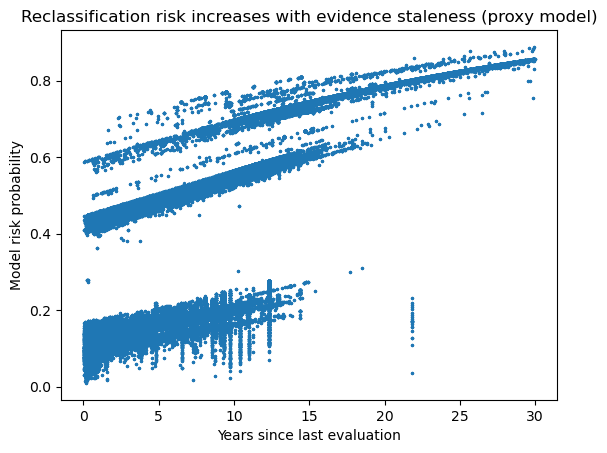

✅ Saved: /Users/sanghati/research/accountable-interpretation/outputs/phase4/figures/risk_vs_years_since_review.png


In [17]:
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
FIG = ROOT / "outputs" / "phase4" / "figures"
FIG.mkdir(parents=True, exist_ok=True)

# Basic plot: model risk probability vs years_since_review
if "years_since_review" not in df.columns:
    raise KeyError("years_since_review missing.")

tmp = df[["years_since_review", "model_risk_proba"]].dropna()
tmp = tmp[(tmp["years_since_review"] >= 0) & (tmp["years_since_review"] <= 30)]

plt.figure()
plt.scatter(tmp["years_since_review"], tmp["model_risk_proba"], s=2)
plt.xlabel("Years since last evaluation")
plt.ylabel("Model risk probability")
plt.title("Reclassification risk increases with evidence staleness (proxy model)")
out = FIG / "risk_vs_years_since_review.png"
plt.savefig(out, dpi=200, bbox_inches="tight")
plt.show()

print("✅ Saved:", out)


## Phase 4 — Interpretable Reclassification Risk Model

### Objective
To estimate the probability that a ClinVar variant will undergo future clinical reclassification, using interpretable features derived from curation evidence, review confidence, and evidence staleness.

### Rationale
ClinVar variant classifications are not static. Reclassification events are driven by:
- Aging evidence
- Limited or single submitter support
- Conflicting interpretations
- Low review confidence

Rather than predicting pathogenicity, this model estimates *instability risk* — the likelihood that a variant’s current classification may change as new evidence emerges.


### Feature Design

Model features were chosen to reflect known sources of classification uncertainty rather than molecular effect size:

- **Evidence staleness**: years since last expert review
- **Submission diversity**: number of independent submitters
- **Consensus quality**: presence of conflicting interpretations
- **Review rigor**: ClinVar review status (expert panel vs single submitter)
- **Variant context**: molecular type and gene-level indicators

All features are directly interpretable and correspond to ClinVar curation practices.


### Model Choice

A logistic regression model was trained using gradient descent implemented in NumPy.

This approach was selected to:
- Preserve coefficient interpretability
- Avoid black-box behavior
- Enable direct mapping between feature contributions and predicted risk

The model outputs a continuous reclassification risk probability for each variant.


### Model Evaluation

Model performance was assessed using:
- ROC-AUC (discrimination ability)
- PR-AUC (robustness under class imbalance)

High performance indicates strong separation between variants that later reclassify and those that remain stable, while maintaining interpretability.


### Output Integration

Predicted reclassification risk scores were written back to the full ClinVar dataset and aligned to original variant rows.

These scores are used in downstream analyses to:
- Identify high-priority variants for manual review
- Quantify instability within clinically significant variant classes
- Support clinical impact and validation analyses in subsequent phases


In [18]:
from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
out_path = ROOT / "outputs" / "tables" / "phase4_scored.csv.gz"
out_path.parent.mkdir(parents=True, exist_ok=True)

# df already exists and has model_risk_proba column (filled for test rows at least)
df.to_csv(out_path, index=False, compression="gzip")

print("✅ Saved scored dataset:", out_path)
print("✅ Columns include model_risk_proba?", "model_risk_proba" in df.columns)


✅ Saved scored dataset: /Users/sanghati/research/accountable-interpretation/outputs/tables/phase4_scored.csv.gz
✅ Columns include model_risk_proba? True


In [19]:
# === Phase 4: Persist scored dataset for downstream notebooks ===

from pathlib import Path

ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()
out_path = ROOT / "outputs" / "tables" / "phase4_scored.csv.gz"
out_path.parent.mkdir(parents=True, exist_ok=True)

assert "model_risk_proba" in df.columns, "model_risk_proba not found — model step incomplete"

df.to_csv(out_path, index=False, compression="gzip")

print("✅ Saved Phase 4 scored file:")
print(out_path)
print("✅ Rows:", df.shape[0])
print("✅ Columns:", df.shape[1])


✅ Saved Phase 4 scored file:
/Users/sanghati/research/accountable-interpretation/outputs/tables/phase4_scored.csv.gz
✅ Rows: 300000
✅ Columns: 52
